# Let's do some Reinforcement Learning practice!

Code: Provided by Sunmook Choi (email: felixchoi@korea.ac.kr)

Today, we will solve an MDP problem using RL algorithms. A code of **SARSA algorithm** is given in this notebook to solve a given problem.


## OpenAI Gymnasium library

- https://gymnasium.farama.org/
- A library that provides a number of (game) environments.

(구) gym --> gymnasium

### Requirements

In [51]:
!pip install gymnasium

In [52]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt

## Taxi Environment

My first choice is `Taxi-v3` environment, which has a discrete state (observation) space and a discrete action space.
- https://gymnasium.farama.org/environments/toy_text/taxi/
- state space: 500 discrete spaces
- action space: 6 discrete actions
- reward function
- Note that we cannot apply RL methods (not DRL methods) on continuous state/action spaces.

We are taxi drivers and there is a passenger. We should
1. move to the passenger,
2. pickup the passenger,
3. move to the destination,
4. drop off the passenger

In [53]:
env = gym.make('Taxi-v3', render_mode='rgb_array') ### rgb array로 보이게 설정하는 것

array([[[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[114, 116, 115],
        [114, 116, 115],
        [126, 127, 126],
        ...,
        [112, 113, 111],
        [112, 113, 111],
        [118, 117, 115]],

       ...,

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[115, 112, 112],
        [115, 112, 112],
        [119, 119, 117],
        ...,
        [123, 119, 118],
        [123, 119, 118],
        [114, 114, 117]]], dtype=uint8)
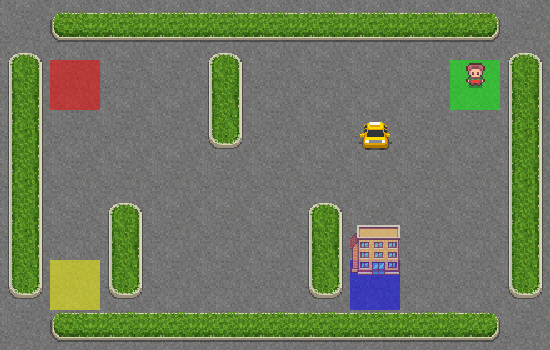

In [54]:
observation, info = env.reset(seed=830) ### 게임을 초기 화면으로 만들어 줌, 시드가 달라지면 게임이 달라짐
env.render() ### ndarray를 만들어서 보여줌

In [55]:
observation

167

In [56]:
info ### prob = 1.0 이라는 것은 action에 대해서 state이 변할 확률이 1.0 이다.

{'prob': 1.0, 'action_mask': array([1, 1, 1, 1, 0, 0], dtype=int8)}

In [57]:
print(env.observation_space.n)
print(env.action_space.n)

500
6


In [58]:
next_state, reward, terminated, truncated, info = env.step(1) ### 액션을 취함, 환경에서 step을 취하고 1을 썼다는 것은 action space 에서 north를 취한다는 것

array([[[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[114, 116, 115],
        [114, 116, 115],
        [126, 127, 126],
        ...,
        [112, 113, 111],
        [112, 113, 111],
        [118, 117, 115]],

       ...,

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[115, 112, 112],
        [115, 112, 112],
        [119, 119, 117],
        ...,
        [123, 119, 118],
        [123, 119, 118],
        [114, 114, 117]]], dtype=uint8)
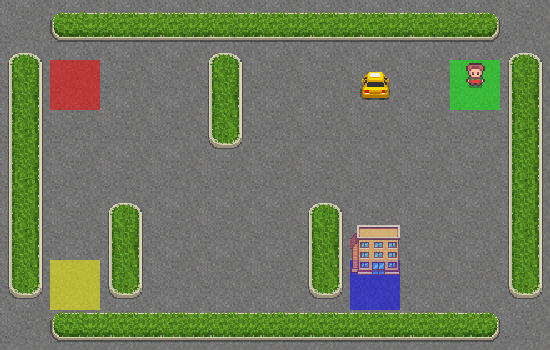

In [59]:
env.render() ### 현 state에 대한 env output이 나옴

In [60]:
print(next_state)
print(reward)
print(terminated) ### 게임이 끝났다는 것을 알림
print(truncated) ### 게임이 너무 길어질 경우를 생각해서 에피소드 하나가 200이 되지 않도록 제한
print(info)

67
-1
False
False
{'prob': 1.0, 'action_mask': array([1, 0, 1, 1, 0, 0], dtype=int8)}


## SARSA

- Sarsa update rule: $Q(S,A) \longleftarrow Q(S,A) + \alpha \, [R + \gamma Q(S',A') - Q(S,A)]$


In [61]:
## Reinforcement Learning is a Q-table updating method!
## This is why continuous state/action spaces are not able to solved using traditional RL methods.

Q_table = np.zeros((env.observation_space.n, env.action_space.n)) ### 500 * 6 짜리 Q table 생성

In [62]:
def sarsa_update_q(state, action, reward, next_state, next_action, Q_table, alpha, gamma):
    Q_table[state, action] += alpha * (reward + gamma*Q_table[next_state, next_action] - Q_table[state, action])
    return Q_table

In [63]:
## Epsilon-greedy policy

def get_action(Q_table, state, epsilon):
    tmp = random.random() ### 0과 1사이의 수를 고름
    if tmp < epsilon:
        # random action with probability epsilon
        return np.random.randint(Q_table.shape[1])
    else:
        # greedy action with probability 1 - epsilon
        return np.argmax(Q_table[state])

In [64]:
def epsilon_schedule(episode, max_episode, initial_eps, final_eps):
    start, end = initial_eps, final_eps
    if episode < max_episode:
        return (start*(max_episode-episode) + end*episode) / max_episode
    else:
        return end

In [65]:
total_rewards = []
episode_lengths = []
max_episode = 2000
initial_epsilon = 1.0
final_epsilon = 0.05
alpha = 0.4
gamma = 1

for episode in range(max_episode):
    terminated = False
    truncated = False
    episode_reward = 0
    episode_length = 0

    epsilon = epsilon_schedule(episode, max_episode//2, initial_epsilon, final_epsilon) ### 왜 2로 나눌까?

    # Initialize the environment
    state, info = env.reset() ### seed를 고정하지 않고 랜덤으로 돌려서 각 에피소드를 다르게 만들어 준다.
    action = get_action(Q_table, state, epsilon)
    episode_length += 1

    while not terminated and not truncated:
        next_state, reward, terminated, truncated, info = env.step(action)
        next_action = get_action(Q_table, next_state, epsilon)
        Q_table = sarsa_update_q(state, action, reward, next_state, next_action, Q_table, alpha, gamma)
        state = next_state
        action = next_action

        episode_reward += reward
        episode_length += 1

    total_rewards.append(episode_reward)
    episode_lengths.append(episode_length)


Text(0, 0.5, 'Episode Length')

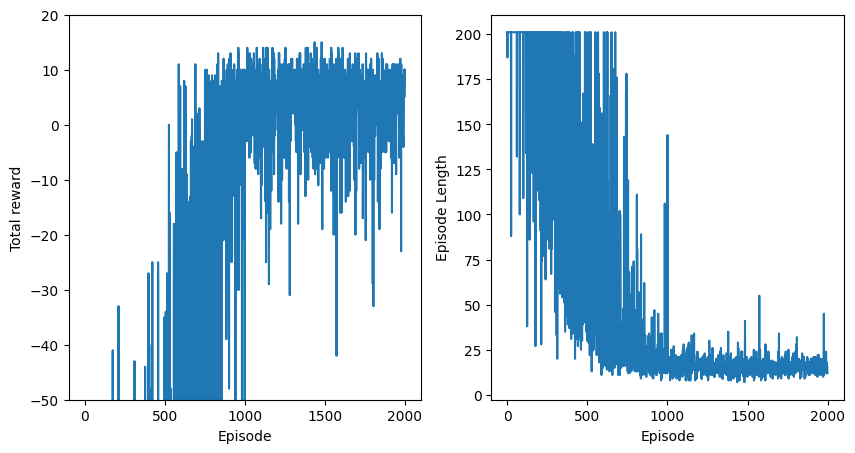

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].plot(np.arange(max_episode), total_rewards, label='SARSA')
axes[0].set_ylim([-50,20])
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Total reward')

axes[1].plot(np.arange(max_episode), episode_lengths, label='SARSA')
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Episode Length')


## Test the trained agent and save it into a GIF.

In [46]:
import PIL.Image
from IPython.display import Image

In [77]:
### 각각의 state에 대한 이미지 array를 렌더해서 render_images에 저장하고 그걸 gif로 변환하는 코드

def play_and_save(Q_table, name='', seed=None):
    render_images = []

    state, _ = env.reset(seed=seed)
    image_array = env.render()
    render_images.append(PIL.Image.fromarray(image_array))

    size = image_array.shape[0], image_array.shape[1]
    terminated, truncated = False, False

    while not terminated and not truncated:
        action = np.argmax(Q_table[state])
        state, reward, terminated, truncated, _ = env.step(action)
        image_array = env.render()
        render_images.append(PIL.Image.fromarray(image_array))

    filename = 'play_'+name+'.gif'

    render_images[0].save(filename, save_all=True, optimize=False, append_images=render_images[1:], duration=500, loop=0)
    ## 저장되는 파일이름, 몰라, 몰라, append할 이미지들, 한 프레임이 넘어가기까지의 시간,
    print('GIF is made successfully!')

    return filename



In [78]:
saved_fname = play_and_save(Q_table, '1', seed=2) ###

GIF is made successfully!


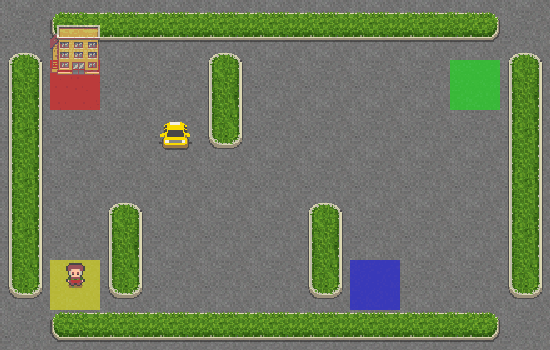

In [79]:
Image(open(saved_fname,'rb').read())

## Homeworks

1. You ***must*** give a better solution using any RL algorithm.
    - 'Better' solution may vary depending on what you are aiming for. Define your own meaning of what a 'better' solution is.
    - Any RL algorithms are allowed. (MC, SARSA, Q-learning, Double Q-learning, etc.)
    - You are ***not allowed*** to use DRL algorithms. For this time, we limit our methods into traditional RL algorithms.
    - You are encouraged to share ideas with others before the next session. If you share ideas, each of you should define your own meaning of 'better' solutions.
    - Each person (or one person from a group) should present his/her/their ideas in the next session.
2. [DIY problem] The following code is a way of choosing an action that is able to change the current state. However, this method does not give a good solution.
    - Why? Think about an answer. (Note: There is indeed an answer to this problem!!)
    - For this question, please ***do not share or discuss your ideas*** with others. Let's take a time to discuss the problem in the next section.
    - Furthermore, I wish to adhere to this action-choosing method. What I should change in the environment so that we can get a good solution with the action-choosing method?
3. What are the roles of the hyperparameters, $\gamma$ and $\alpha$, for training SARSA? What would happend if I modify the values?
    - Bring your own thoughts and share them with us in the next session.
    - If possible, you are encouraged to show the supporting experiments for your thoughts.

### Second Homework Code

Text(0, 0.5, 'Episode Length')

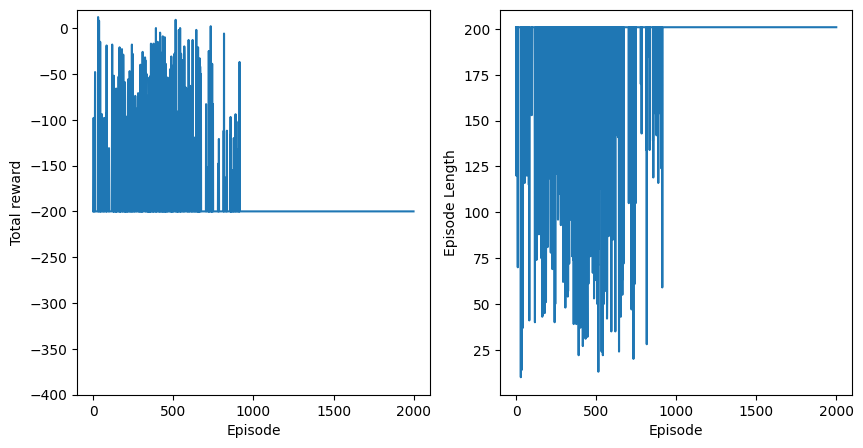

In [80]:
Q_table2 = np.zeros((env.observation_space.n, env.action_space.n))


def get_action2(Q_table, state, epsilon, info):

    tmp = random.random()

    if tmp < epsilon:
        # random action with probability epsilon
        return np.random.choice(np.where(info['action_mask']==1)[0])
    else:
        # greedy action with probability 1 - epsilon
        return np.argmax(Q_table2[state, np.where(info['action_mask']==1)[0]])

total_rewards = []
episode_lengths = []
max_episode = 2000
initial_epsilon = 1.0
final_epsilon = 0.05
alpha = 0.4
gamma = 1

for episode in range(max_episode):
    terminated = False
    truncated = False
    episode_reward = 0
    episode_length = 0

    epsilon = epsilon_schedule(episode, max_episode//2, initial_epsilon, final_epsilon)

    # Initialize the environment
    state, info = env.reset()
    action = get_action2(Q_table2, state, epsilon, info)
    episode_length += 1

    while not terminated and not truncated:
        next_state, reward, terminated, truncated, info = env.step(action)
        next_action = get_action2(Q_table2, next_state, epsilon, info)
        Q_table2 = sarsa_update_q(state, action, reward, next_state, next_action, Q_table2, alpha, gamma)
        state = next_state
        action = next_action

        episode_reward += reward
        episode_length += 1

    total_rewards.append(episode_reward)
    episode_lengths.append(episode_length)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].plot(np.arange(max_episode), total_rewards, label='SARSA')
axes[0].set_ylim([-400,20])
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Total reward')

axes[1].plot(np.arange(max_episode), episode_lengths, label='SARSA')
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Episode Length')


In [81]:
saved_fname2 = play_and_save(Q_table2, '2', seed=8)

GIF is made successfully!


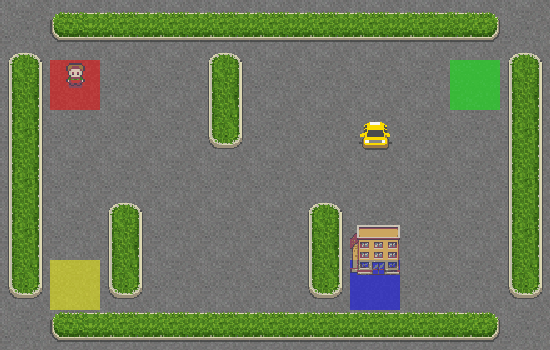

In [82]:
Image(open(saved_fname2,'rb').read())